# Factor Models & Risk Analysis

In [ ]:
import yfinance as yf
import pandas as pd
import pandas_datareader.data as web
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# 1. Data Acquisition & Preparation

In [13]:
#  Analysis Parameters 
tickers = ['TSLA', 'F']
start_date = '2014-01-01'
end_date = '2023-12-31'

#  Download Stock Data 
print("Downloading stock data...")
stock_data_daily = yf.download(tickers, start=start_date, end=end_date)['Close']
stock_data_monthly = stock_data_daily.resample('M').last()
monthly_returns = stock_data_monthly.pct_change().dropna()
# Convert to PeriodIndex to match Fama-French data format
monthly_returns.index = monthly_returns.index.to_period('M')
print("Stock data ready.\n")

# Download Fama-French 5-Factor Data
print("Downloading Fama-French data...")
# Use the correct dataset name for monthly 5-factor data
ff_factors_raw = web.get_data_famafrench('F-F_Research_Data_5_Factors_2x3', start=start_date, end=end_date)
ff_factors = ff_factors_raw[0] / 100 # [0] selects the monthly data
ff_factors.rename(columns={'Mkt-RF': 'Mkt_RF'}, inplace=True)
print("Fama-French data ready.\n")

#  Merge and Prepare Final DataFrame
print("Merging data...")
final_df = monthly_returns.join(ff_factors)
for ticker in tickers:
    final_df[f'{ticker}_excess'] = final_df[ticker] - final_df['RF']
final_df.dropna(inplace=True)

print("\n--- Final DataFrame ready for analysis ---")
print(final_df.head(3))

[*********************100%***********************]  2 of 2 completed

Stock data ready.



Fama-French data ready.

Merging data...

--- Final DataFrame ready for analysis ---
                F      TSLA  Mkt_RF     SMB     HML     RMW     CMA   RF  \
Date                                                                       
2014-02  0.028744  0.349485  0.0468  0.0013 -0.0035 -0.0025 -0.0054  0.0   
2014-03  0.013645 -0.148523  0.0041 -0.0113  0.0490  0.0202  0.0192  0.0   
2014-04  0.043347 -0.002687 -0.0019 -0.0407  0.0122  0.0340  0.0093  0.0   

         TSLA_excess  F_excess  
Date                            
2014-02     0.349485  0.028744  
2014-03    -0.148523  0.013645  
2014-04    -0.002687  0.043347  


# 2. Regression Analysis & Visualization

Running Regressions...

--- R-squared Comparison for TSLA ---
  Adj. R-squared (CAPM): 0.2454
  Adj. R-squared (Fama-French 3): 0.2921
  Adj. R-squared (Fama-French 5): 0.2917

--- R-squared Comparison for F ---
  Adj. R-squared (CAPM): 0.4055
  Adj. R-squared (Fama-French 3): 0.4567
  Adj. R-squared (Fama-French 5): 0.4543


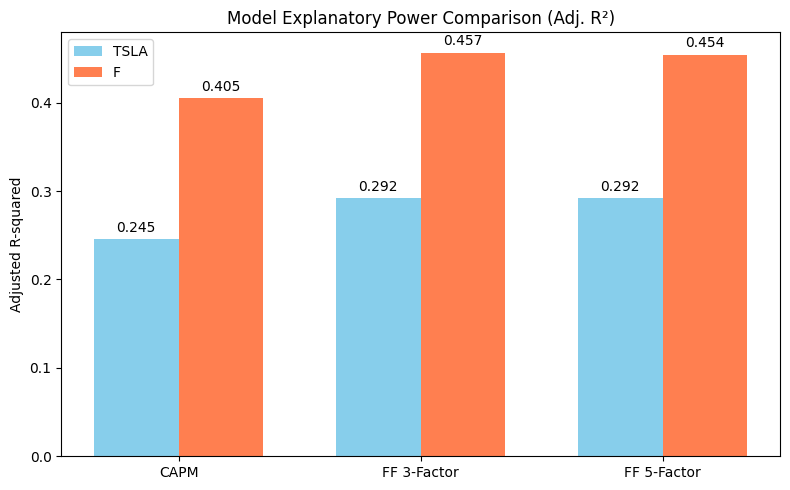

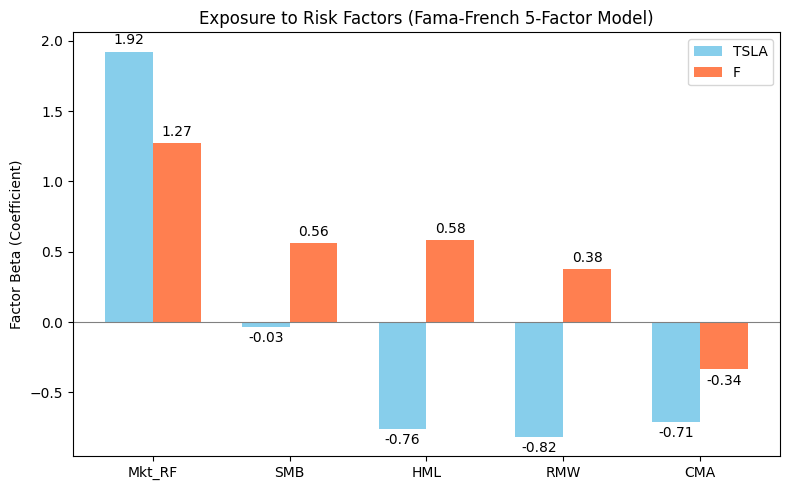

In [15]:
def run_all_regressions(ticker, data):
    """
    Runs CAPM, Fama-French 3-Factor, and Fama-French 5-Factor regressions.
    Returns a dictionary containing the results of each model.
    """
    y = data[f'{ticker}_excess']
    
    # Define independent variables for each model
    X_capm = sm.add_constant(data['Mkt_RF'])
    X_ff3 = sm.add_constant(data[['Mkt_RF', 'SMB', 'HML']])
    X_ff5 = sm.add_constant(data[['Mkt_RF', 'SMB', 'HML', 'RMW', 'CMA']])
    
    # Fit the OLS models
    capm_model = sm.OLS(y, X_capm).fit()
    ff3_model = sm.OLS(y, X_ff3).fit()
    ff5_model = sm.OLS(y, X_ff5).fit()
    
    # Print R-squared comparison
    print(f"\n--- R-squared Comparison for {ticker} ---")
    print(f"  Adj. R-squared (CAPM): {capm_model.rsquared_adj:.4f}")
    print(f"  Adj. R-squared (Fama-French 3): {ff3_model.rsquared_adj:.4f}")
    print(f"  Adj. R-squared (Fama-French 5): {ff5_model.rsquared_adj:.4f}")
    
    return {'capm': capm_model, 'ff3': ff3_model, 'ff5': ff5_model}

# Run analyses and store results
print("="*80)
print("Running Regressions...")
tsla_results = run_all_regressions('TSLA', final_df)
ford_results = run_all_regressions('F', final_df)
print("="*80)

#  Adjusted R-squared Comparison
models = ['CAPM', 'FF 3-Factor', 'FF 5-Factor']
tsla_r2 = [tsla_results['capm'].rsquared_adj, tsla_results['ff3'].rsquared_adj, tsla_results['ff5'].rsquared_adj]
ford_r2 = [ford_results['capm'].rsquared_adj, ford_results['ff3'].rsquared_adj, ford_results['ff5'].rsquared_adj]

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
rects1 = ax.bar(x - width/2, tsla_r2, width, label='TSLA', color='skyblue')
rects2 = ax.bar(x + width/2, ford_r2, width, label='F', color='coral')

ax.set_ylabel('Adjusted R-squared')
ax.set_title('Model Explanatory Power Comparison (Adj. R²)')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
ax.bar_label(rects1, padding=3, fmt='%.3f')
ax.bar_label(rects2, padding=3, fmt='%.3f')
fig.tight_layout()
plt.savefig('r_squared_comparison.png', dpi=300) 
plt.show()

#  5-Factor Model Beta Coefficients Comparison
factors = ['Mkt_RF', 'SMB', 'HML', 'RMW', 'CMA']
tsla_betas = tsla_results['ff5'].params.drop('const')
ford_betas = ford_results['ff5'].params.drop('const')

x = np.arange(len(factors))

fig, ax = plt.subplots(figsize=(8, 5))
rects1 = ax.bar(x - width/2, tsla_betas, width, label='TSLA', color='skyblue')
rects2 = ax.bar(x + width/2, ford_betas, width, label='F', color='coral')

ax.axhline(0, color='grey', linewidth=0.8) # Add a zero line
ax.set_ylabel('Factor Beta (Coefficient)')
ax.set_title('Exposure to Risk Factors (Fama-French 5-Factor Model)')
ax.set_xticks(x)
ax.set_xticklabels(factors)
ax.legend()
ax.bar_label(rects1, padding=3, fmt='%.2f')
ax.bar_label(rects2, padding=3, fmt='%.2f')
fig.tight_layout()
plt.savefig('factor_betas_comparison.png', dpi=300) # Save the figure
plt.show()

### Analysis of Results 

The regression analysis and visualizations provide a clear and compelling narrative about what drives the returns of Tesla and Ford.

#### Finding 1: Fama-French Models Offer Superior Explanatory Power

The first bar chart definitively shows that both the 3-Factor and 5-Factor Fama-French models explain a significantly higher portion of the stock return variance (higher Adjusted R²) compared to the basic CAPM. This confirms that factors beyond simple market risk are crucial for understanding stock performance.

Interestingly, the 5-Factor model offers little to no improvement over the 3-Factor model for these specific stocks, suggesting that the core drivers for TSLA and F within this period are primarily Market, Size, and Value.

#### Finding 2: Quantifying the "Growth" vs. "Value" Profile

The second bar chart visualizes the "risk DNA" of each stock according to the 5-Factor model:
*   **Market Risk (Mkt_RF):** Both stocks have a beta greater than 1, with TSLA (1.92) being substantially more volatile than F (1.27).
*   **Value Factor (HML):** This is the key finding. **Ford** shows a strong positive exposure (0.58), quantitatively confirming its status as a **Value Stock**. In contrast, **Tesla** has a strong negative exposure (-0.76), proving it behaves as a classic **Growth Stock**.
*   **Profitability Factor (RMW):** Tesla's significant negative exposure (-0.82) reflects its historical focus on reinvesting for growth over demonstrating robust current profits, a typical trait of growth companies. Ford's positive exposure (0.38) aligns with its nature as an established, profitable company.

### Conclusion

This analysis successfully demonstrated the superiority of multi-factor models over the traditional CAPM. By applying the Fama-French 5-Factor model, we were able to move beyond simple labels and **quantitatively prove** the distinct risk profiles of Tesla (as a volatile, aggressive-investment Growth stock) and Ford (as a more stable Value stock). This approach provides a robust framework for dissecting and understanding the fundamental drivers of asset returns.